### The logistic map
Is defined as $x_{i + 1} = \alpha x_{i}(1 - x_{i})$. For $\alpha = 4$ it maps $[0,1]$ onto itself. For $\alpha = 4$ the invariant density is $$ \pi(dx) := \frac{1}{\pi\sqrt{x(1 - x)}}dx,$$
which is a beta distribution with parameters $a = b = 0.5$.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
from scipy.stats import beta
import sys
sys.path.append("../../")
from DynamicalSystems.koopman_regression import KernelRidgeRegression, ReducedRankRegression, PrincipalComponentRegression
from DynamicalSystems.kernels import Linear, Quadratic, RBF, Matern

In [2]:
a, b = 0.5, 0.5
def logistic_map(x, r = 4):
    return r * x * (1 - x)

In [23]:
kernel = Matern(nu=0.5, length_scale=0.5)
rank = 20
estimators = [PrincipalComponentRegression, ReducedRankRegression, KernelRidgeRegression]
train_max = 1000
train_sizes = np.arange(0, train_max + 1, 20)[1:]

test_size = 100
test_repetitions = 100
test_X = beta.rvs(a, b, size = (test_size, test_repetitions))
test_Y = np.empty_like(test_X)

for i in range(test_repetitions):
    test_Y[:,i] = logistic_map(test_X[:,i])

train_repetitions = 1

errors = np.zeros((len(train_sizes), test_repetitions, len(estimators)))

for i, estimator in enumerate(estimators):
    for j, train_size in tqdm(enumerate(train_sizes), desc = f'{estimator.__name__}', total = len(train_sizes)):
        X = beta.rvs(a, b, size = train_size)[:, None]
        Y = logistic_map(X)
        tikhonov_reg = 0.01*train_size**(-0.5)
        if estimator == KernelRidgeRegression:
            e = estimator(kernel, tikhonov_reg=tikhonov_reg)
        else:
            e = estimator(kernel, rank, tikhonov_reg=tikhonov_reg)
        e.fit(X, Y, backend='cpu')
        for k in range(test_repetitions):
            errors[j,k,i] = e.risk(test_X[:,k][:, None], test_Y[:,k][:, None])

KernelRidgeRegression: 100%|██████████| 50/50 [00:26<00:00,  1.88it/s]


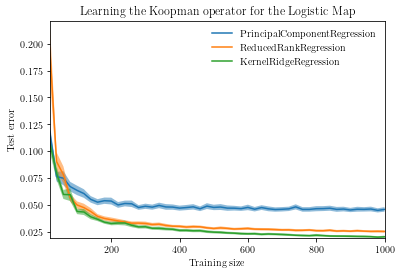

In [25]:
for idx, estimator in enumerate(estimators):
    mean = np.mean(errors[:,:,idx], axis = 1)
    std = np.std(errors[:,:,idx], axis = 1)
    plt.fill_between(train_sizes, mean - std, mean + std, alpha = 0.5)
    plt.plot(train_sizes, mean, '-', label = estimator.__name__)
plt.margins(0)
plt.legend(frameon=False)
plt.ylabel("Test error")
plt.xlabel("Training size")
plt.title("Learning the Koopman operator for the Logistic Map")
plt.savefig("figs/logistic_map_error.pdf")